In [1]:
import numpy as np
from scipy import linalg

import pandas as pd


from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt

import gc

%matplotlib inline

In [2]:
sample = 128 #hz
trial_time = 3 #s

origin_channel = 5 #5 channel eeg


In [3]:
def cov_mat(X):
    return np.matmul(X , X.T)/np.trace(np.matmul(X , X.T))

#计算每种样本的平均协方差矩阵
def average_norm_cov_mat(data):
    count = data.shape[0]
    sum_mat = np.zeros(shape=(data[0].shape[0] , data[0].shape[0]))
    
    for i in range(count):
        sum_mat += cov_mat(data[i])
    
    return sum_mat/count

def load_data(file_name):
    #pink and white
    
    temp = pd.read_csv(file_name)
    
    #删除前3秒和后2秒数据
    temp = temp.iloc[ : temp.shape[0] - 2*128] #后2秒 2s sample:128hz
    temp = temp.iloc[3*128 : ] #前3秒 3s sample:128hz
    
    for column in temp.columns:
        temp[column] = (temp[column] - temp[column].mean())/temp[column].std() #norm
    
    #5 channels data
    return temp[['AF3' , 'T7','Pz' , 'T8' , 'AF4']]

def sep(one_data , label):
    train_data = []
    train_labels = []
    
    size = sample*trial_time #384
    
    for i in range(one_data.shape[0] - size):
        train_data.append(one_data.iloc[i : i+size].values) #add one train sample
        train_labels.append(label) #corresponding label
    
    return train_data , train_labels

In [4]:
def concat_eeg_csv(file_names):
    #concat a big csv file
    first_file = load_data(file_name = file_names[0])
    
    file_names.remove(file_names[0])
    
    for file_name in file_names:
        first_file = first_file.append(load_data(file_name = file_name) , ignore_index = True)
    
    return first_file

In [5]:
#在进行聚类时 CSP算法后特征变为2维 新生成的特征为2维的

m = 1 #选取最高m个特征向量 m最小为1
def CSP_matrix(train_data_1 , train_data_2):
    #计算投影矩阵
    R_pink = average_norm_cov_mat(train_data_1)
    R_white = average_norm_cov_mat(train_data_2)
    
    R = R_pink + R_white
    
    eigenvalues , U0 = np.linalg.eig(R)

    sort_index = np.argsort(eigenvalues)
    sort_index = sort_index[:: -1]

    U0 = U0[: , sort_index]
    eigenvalues = sorted(eigenvalues , reverse=True)

    sigma = np.diag(eigenvalues)
    
    #白化矩阵
    P = np.matmul(np.diag(np.power(eigenvalues , -0.5)) , U0.T)
    
    S_pink = np.matmul(np.matmul(P , R_pink) , P.T)
    S_white = np.matmul(np.matmul(P , R_white) , P.T)
    
    E1 , US1 = np.linalg.eig(S_pink)
    E2 , US2 = np.linalg.eig(S_white)

    #E1+E2=I
    #US1=US2
    
    sort_index_1 = np.argsort(E1)
    sort_index_1 = sort_index_1[:: -1]
    
    E1 = sorted(E1 , reverse=True)
    US1 = US1[: , sort_index_1]
    
    W_1 = np.matmul(US1[: , 0:m].T , P) #前2列特征向量
    #=======================
    sort_index_2 = np.argsort(E2)
    sort_index_2 = sort_index_2[:: -1]
    
    E2 = sorted(E2 , reverse=True)
    US2 = US2[: , sort_index_2]
    
    W_2 = np.matmul(US2[: , 0:m].T , P) #前2列特征向量
    
    return W_1 , W_2

In [6]:
#low pass filter
#50Hz

def low_pass(data):
    point = 50 #highest freq = 50hz
    length = sample * trial_time #256
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            a = np.fft.fft(data[i][j]).real
            b = np.fft.fft(data[i][j]).imag
            a[point : length-point] = 0
            b[point : length-point] = 0
            #重建频谱
            new_freq = [np.complex(a[i] , b[i]) for i in range(length)]
            new_freq = np.array(new_freq)
            
            data[i][j] = np.fft.ifft(new_freq)
        
    return data


In [58]:
#使用白色
#data_1 = concat_eeg_csv(['data/train_1/fei_white_1.csv' , 'data/train_1/fei_white_2.csv' , 'data/val_1/fei_white_3.csv'])
#data_2 = concat_eeg_csv(['data/train_1/sen_white_1.csv' , 'data/train_1/sen_white_2.csv' , 'data/val_1/sen_white_3.csv'])

#使用粉色
data_1 = concat_eeg_csv(['data/train_1/fei_pink_1.csv' , 'data/train_1/fei_pink_2.csv' , 'data/val_1/fei_pink_3.csv'])
data_2 = concat_eeg_csv(['data/train_1/sen_pink_1.csv' , 'data/train_1/sen_pink_2.csv' , 'data/val_1/sen_pink_3.csv'])

train_data_1 , train_labels_1 = sep(data_1 , 0)
train_data_2 , train_labels_2 = sep(data_2 , 1)

train_data_1 = np.array(train_data_1)
train_data_2 = np.array(train_data_2)

train_labels_1 = np.array(train_labels_1)
train_labels_2 = np.array(train_labels_2)

train_data_1 = np.transpose(train_data_1 , axes=(0 , 2 , 1))
train_data_2 = np.transpose(train_data_2 , axes=(0 , 2 , 1))

In [59]:
print(train_data_1.shape , train_data_2.shape)

(13020, 5, 384) (37769, 5, 384)


In [60]:
#=============
#滤波阶段 此时一个小样本为3秒的数据量  此时大致认为信号为平稳的
train_data_1 = low_pass(train_data_1)
train_data_2 = low_pass(train_data_2)

I:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


In [61]:
W_1 , W_2 = CSP_matrix(train_data_1 , train_data_2)

In [62]:
W_1

array([[ 1.17557999, -1.6001874 ,  0.16565894,  0.44976101,  0.03979761]])

In [63]:
W_2

array([[-0.22585658, -0.67796765, -0.44420474, -0.82418679,  0.7018964 ]])

In [64]:
train_data = np.concatenate((train_data_1 , train_data_2))

train_labels = np.concatenate((train_labels_1 , train_labels_2))

train_data_features = []

In [65]:
print(train_data.shape , train_labels.shape)

(50789, 5, 384) (50789,)


In [46]:
def fetch_feature(xi):
    #m = 2 #2*m features
    #
    #Z = np.matmul(W , xi)
    #
    #Z_pre_m = Z[0:m ,:]
    #Z_after_m = Z[-m: , :]
    #
    #Zp = np.concatenate((Z_pre_m , Z_after_m))
    #
    #sigma_var_Zp = 0
    #
    #for i in range(2*m):
    #    sigma_var_Zp += np.var(Zp[i])
    #    
    #fi = [np.log(np.var(Zpi)/sigma_var_Zp) for Zpi in Zp]
    #
    #fi = np.array(fi)
    
    #======
    #特征维数较低时 例如低于100
    #fi = np.concatenate([np.matmul(W_1 , xi) , np.matmul(W_2 , xi)])
    #======
    
    
    '''特征提取方式1'''
    z1 = np.matmul(W_1 , xi) #m*384  #在聚类情况下 m等于1
    z2 = np.matmul(W_2 , xi) #m*384
    
    #zz1 = np.sum(z1 , axis = 1)[0]
    var_z1_1 = np.var(z1 , axis = 1)[0]
    ##var_z1_2 = np.var(z1 , axis = 1)[1]
    
    #zz2 = np.sum(z2 , axis = 1)[0]
    var_z2_1 = np.var(z2 , axis = 1)[0]
    ##var_z2_2 = np.var(z2 , axis = 1)[1]
    
    #f1 = var_z1_1/(var_z1_1+var_z2_1)
    #f2 = var_z2_1/(var_z1_1+var_z2_1)
    ##f3 = var_z1_2/(var_z1_2+var_z2_2)
    ##f4 = var_z2_2/(var_z1_2+var_z2_2)
    
    #return np.array([zz1 , zz2])
    return np.array([var_z1_1 , var_z2_1])

    #==========
    
    '''特征提取方式2'''
    #z1 = np.matmul(W_1 , xi) #2*384
    #z2 = np.matmul(W_2 , xi) #2*384
    #return np.concatenate((z1 , z2))
    

In [66]:
for i in range(train_data.shape[0]):
    train_data_features.append(fetch_feature(train_data[i]))

train_data_features = np.array(train_data_features)

In [67]:
print(train_data_features.shape , train_labels.shape)

(50789, 2) (50789,)


In [68]:
train_data_features[0]

array([2.93915883, 0.05561935])

In [69]:
train_data_features[100]

array([5.303072  , 0.28528421])

In [36]:
#===========
#===========
#开始聚类过程

In [72]:
#==========
#==========
#dbscan
dbscan = DBSCAN(eps=0.25) #粉色的时候 将eps参数设置为0.25 白色的时候 使用默认的参数

dbscan.fit(train_data_features , train_labels)

DBSCAN(algorithm='auto', eps=0.25, leaf_size=30, metric='euclidean',
    min_samples=5, n_jobs=1, p=None)

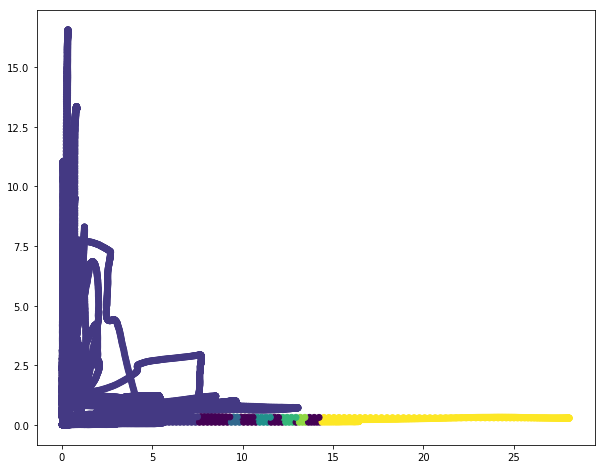

In [73]:
plt.figure(figsize=(10 , 8))
plt.scatter(train_data_features[: , 0] , train_data_features[: , 1]  , c = dbscan.labels_)
#plt.title('cluster eeg(cluster label)')

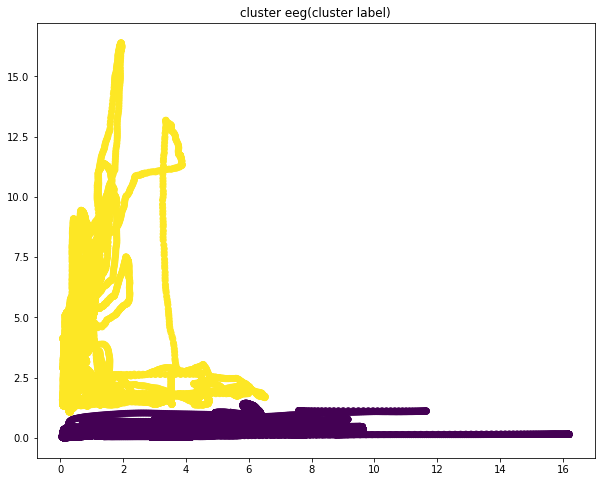

In [53]:
plt.figure(figsize=(10 , 8))
plt.scatter(train_data_features[: , 0] , train_data_features[: , 1] , c = train_labels)
plt.title('cluster eeg(cluster label)')